## Import libraries

In [87]:
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt
from time import time
from torchvision import datasets, transforms
from torch import nn,optim
from torch.utils.data import TensorDataset,DataLoader
import itertools

## Download Dataset

In [88]:
training_set = datasets.MNIST('/content',train=True,download=True)
testing_set = datasets.MNIST('/content',train=False,download=True)

## Prepare the data

In [89]:
invert = lambda image : 1 - image # function to invert the image
normalize = lambda image : image / 255 # function for bringing pixel values in range [0,1]

def prepare_data(dataset,digit):
    dataset_images = dataset.data.numpy() # convert the dataset into numpy array
    dataset_labels = dataset.targets.numpy() # convert the labels into numpy array
    dataset_images = normalize(dataset_images)
    
    indices = np.asarray(np.where(dataset_labels == digit)) # indices of occurrence of digit as label
    indices = indices.flatten()
    num_of_examples = len(indices) # total number of examples of this digit
    
    dataset_images_positive = dataset_images[indices] # images consisting of positive class
    # positive class has all labels as 1s
    dataset_labels_positive = np.full(shape=num_of_examples,fill_value=1,dtype=np.int64) 
    dataset_images_negative = invert(dataset_images_positive) # images consisting of negative class
    # negative class has all labels as 0s
    dataset_labels_negative = np.full(shape=num_of_examples,fill_value=0,dtype=np.int64) 

    modified_dataset_images = np.concatenate((dataset_images_positive,dataset_images_negative))
    modified_dataset_labels = np.concatenate((dataset_labels_positive,dataset_labels_negative))
    tensor_x = torch.Tensor(modified_dataset_images)
    tensor_y = torch.Tensor(modified_dataset_labels)
    new_dataset = TensorDataset(tensor_x,tensor_y)
    return new_dataset

train_digit_set = prepare_data(training_set,0) # fetch the training set for a digit
test_digit_set = prepare_data(testing_set,0) # fetch the test set for a digit
train_loader = DataLoader(train_digit_set,batch_size=64,shuffle=True)
test_loader = DataLoader(test_digit_set,batch_size=64,shuffle=True)

### Plotting some data

torch.float32


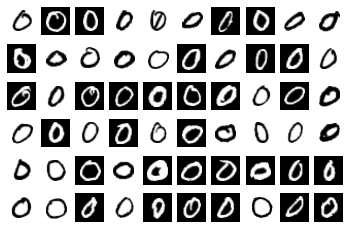

In [90]:
dataiter = iter(train_loader)
images,labels = dataiter.next()
print(labels.dtype)
figure = plt.figure()
num_of_images = 60
for index in range(1,num_of_images+1):
    plt.subplot(6,10,index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(),cmap='gray_r')

## Build the neural network

In [91]:
input_size = 784
hidden_sizes = [128,64]
output_size = 1

model = nn.Sequential(
    nn.Linear(input_size,hidden_sizes[0]),
    nn.ReLU(),
    nn.Linear(hidden_sizes[0],hidden_sizes[1]),
    nn.ReLU(),
    nn.Linear(hidden_sizes[1],output_size),
    nn.Sigmoid()
)

criterion = nn.BCELoss()
print(model)
optimizer = optim.SGD(model.parameters(),lr = 0.003,momentum=0.9)
time0 = time()
epochs = 15
for e in range(epochs):
    for images,labels in train_loader:
        images = images.view(images.shape[0],-1) # flatten the image
        optimizer.zero_grad() # training pass
        output = model(images)
        labels = labels.unsqueeze(1)
        loss = criterion(output,labels)
        loss.backward() # backpropagation
        optimizer.step() # optimizes its weights here
        
print(f"\nTraining time in minutes = {(time()-time0)/60}")

Sequential(
  (0): Linear(in_features=784, out_features=128, bias=True)
  (1): ReLU()
  (2): Linear(in_features=128, out_features=64, bias=True)
  (3): ReLU()
  (4): Linear(in_features=64, out_features=1, bias=True)
  (5): Sigmoid()
)

Training time in minutes = 0.12198647658030191


## Testing

In [92]:
correct_outputs = 0
total_outputs = 0
for images,labels in test_loader:
    for i in range(len(labels)):
        img = images[i].view(1,784)
        with torch.no_grad():
            logps = model(img)
        pred_label = torch.round(logps)
        true_label = labels.numpy()[i]
        if true_label == pred_label:
            correct_outputs += 1
        total_outputs += 1
print(f"\nModel Accuracy : {correct_outputs / total_outputs}")


Model Accuracy : 1.0


## Save the Model

In [93]:
torch.save(model,'./mnist_model.pt')